In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset, TensorDataset
import numpy as np

from sklearn.datasets import fetch_openml
from sklearn.metrics.pairwise import pairwise_kernels
from sklearn.kernel_ridge import KernelRidge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
import torch.optim as optim

In [3]:
seed = 1234
np.random.seed(seed)
torch.manual_seed(seed)

In [4]:
def evaluate_sklearn_model(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return y_pred

In [5]:
class TwoLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

class FiveLayerNN(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim), nn.ReLU(),
            nn.Linear(hidden_dim, 1), nn.Sigmoid()
        )

    def forward(self, x):
        return self.net(x)

In [6]:
def train_pytorch_model(model, X_train, y_train, X_test, y_test, epochs=100, lr=1e-3):
    criterion = nn.BCELoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    X_train_t = torch.tensor(X_train, dtype=torch.float32)
    y_train_t = torch.tensor(y_train, dtype=torch.float32).unsqueeze(1)

    X_test_t = torch.tensor(X_test, dtype=torch.float32)
    y_test_t = torch.tensor(y_test, dtype=torch.float32).unsqueeze(1)

    model.train()
    for epoch in range(epochs):
        optimizer.zero_grad()
        output = model(X_train_t)
        loss = criterion(output, y_train_t)
        loss.backward()
        optimizer.step()

    model.eval()
    with torch.no_grad():
        y_pred_prob = model(X_test_t).squeeze().numpy()
        y_pred = (y_pred_prob >= 0.5).astype(int)

    return y_pred, y_pred_prob

In [7]:
def compute_metrics(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    tpr = tp / (tp + fn)  # Recall
    fpr = fp / (fp + tn)
    return acc, tpr, fpr

In [8]:
def get_data(seed):
  # Transform to normalize to [0, 1]
  transform = transforms.Compose([
      transforms.ToTensor()
  ])

  mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

  indices_4 = [i for i, (img, label) in enumerate(mnist) if label == 4][:5000]
  indices_9 = [i for i, (img, label) in enumerate(mnist) if label == 9][:5000]

  all_indices = indices_4 + indices_9
  filtered_dataset = Subset(mnist, all_indices)

  images = torch.stack([filtered_dataset[i][0] for i in range(len(filtered_dataset))])
  labels = torch.tensor([filtered_dataset[i][1] for i in range(len(filtered_dataset))])

  # Flatten each image to vector x̃ ∈ ℝᴰ, where D = 28*28
  images = images.view(images.size(0), -1)

  images_4 = images[:5000]
  images_9 = images[5000:]
  labels_4 = labels[:5000]
  labels_9 = labels[5000:]

  x4_train, x4_test, y4_train, y4_test = train_test_split(images_4, labels_4, train_size=0.8, random_state=seed)
  x9_train, x9_test, y9_train, y9_test = train_test_split(images_9, labels_9, train_size=0.8, random_state=seed)

  return x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test

In [13]:
def compute_pca_scores(X, M):
    # Center data
    mean = X.mean(dim=0)
    X_centered = X - mean

    # Convert to numpy for SVD
    X_np = X_centered.numpy()

    # Compute covariance matrix
    cov = np.cov(X_np, rowvar=False)

    # Eigen decomposition
    eigvals, eigvecs = np.linalg.eigh(cov)

    # Sort by descending eigenvalues
    sorted_indices = np.argsort(eigvals)[::-1]
    eigvecs = eigvecs[:, sorted_indices]

    # Select top M eigenvectors
    V_m = eigvecs[:, :M]  # D x M

    # Compute PC scores: N x D @ D x M = N x M
    Z = X_np @ V_m
    return Z, V_m, mean

In [14]:
def prepare_separate_pca_data(x4_train, x4_test, y4_train, y4_test,
                              x9_train, x9_test, y9_train, y9_test,
                              M):
    # Compute PCA separately on each digit's training data
    Z4_train, V4_m, mean4 = compute_pca_scores(x4_train, M)
    Z9_train, V9_m, mean9 = compute_pca_scores(x9_train, M)

    # Apply same PCA transforms to respective test sets
    x4_test_centered = x4_test - mean4
    Z4_test = x4_test_centered.numpy() @ V4_m

    x9_test_centered = x9_test - mean9
    Z9_test = x9_test_centered.numpy() @ V9_m

    # Combine training sets
    Z_train = np.concatenate([Z4_train, Z9_train], axis=0)
    y_train = torch.cat([y4_train, y9_train], dim=0).numpy()

    # Combine test sets
    Z_test = np.concatenate([Z4_test, Z9_test], axis=0)
    y_test = torch.cat([y4_test, y9_test], dim=0).numpy()

    return Z_train, y_train, Z_test, y_test

In [9]:
def map_labels(y):
    return np.where(y == 4, 1, 0)

In [15]:
x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test = get_data(seed=42)

100%|██████████| 9.91M/9.91M [00:00<00:00, 33.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.31MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 10.7MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.50MB/s]


In [20]:
# Store results
results = {
    "Perceptron": [],
    "LogReg": [],
    "2Layer_100": [],
    "2Layer_400": [],
    "5Layer_100": [],
    "5Layer_400": []
}

for M in range(1, 11):
    print(f"\n==== M = {M} ====")

    # Step 1: PCA separately for digits 4 and 9
    Z_train, y_train, Z_test, y_test = prepare_separate_pca_data(
        x4_train, x4_test, y4_train, y4_test,
        x9_train, x9_test, y9_train, y9_test,
        M=M
    )

    y_train_bin = map_labels(y_train)
    y_test_bin = map_labels(y_test)
    input_dim = Z_train.shape[1]

    # Step 2: Train and evaluate each model

    # Perceptron
    perceptron = Perceptron(max_iter=1000, tol=1e-3)
    y_pred_p = evaluate_sklearn_model(perceptron, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_p, tpr_p, fpr_p = compute_metrics(y_test_bin, y_pred_p)
    results["Perceptron"].append(acc_p)
    print(f"Perceptron    - Acc: {acc_p:.4f}, TPR: {tpr_p:.4f}, FPR: {fpr_p:.4f}")

    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    y_pred_l = evaluate_sklearn_model(logreg, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_l, tpr_l, fpr_l = compute_metrics(y_test_bin, y_pred_l)
    results["LogReg"].append(acc_l)
    print(f"Logistic Reg  - Acc: {acc_l:.4f}, TPR: {tpr_l:.4f}, FPR: {fpr_l:.4f}")

    # 2-layer NN (100)
    model_2_100 = TwoLayerNN(input_dim, 100)
    y_pred_2_100, _ = train_pytorch_model(model_2_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_100, tpr_2_100, fpr_2_100 = compute_metrics(y_test_bin, y_pred_2_100)
    results["2Layer_100"].append(acc_2_100)
    print(f"2-Layer (100) - Acc: {acc_2_100:.4f}, TPR: {tpr_2_100:.4f}, FPR: {fpr_2_100:.4f}")

    # 2-layer NN (400)
    model_2_400 = TwoLayerNN(input_dim, 400)
    y_pred_2_400, _ = train_pytorch_model(model_2_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_400, tpr_2_400, fpr_2_400 = compute_metrics(y_test_bin, y_pred_2_400)
    results["2Layer_400"].append(acc_2_400)
    print(f"2-Layer (400) - Acc: {acc_2_400:.4f}, TPR: {tpr_2_400:.4f}, FPR: {fpr_2_400:.4f}")

    # 5-layer NN (100)
    model_5_100 = FiveLayerNN(input_dim, 100)
    y_pred_5_100, _ = train_pytorch_model(model_5_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_100, tpr_5_100, fpr_5_100 = compute_metrics(y_test_bin, y_pred_5_100)
    results["5Layer_100"].append(acc_5_100)
    print(f"5-Layer (100) - Acc: {acc_5_100:.4f}, TPR: {tpr_5_100:.4f}, FPR: {fpr_5_100:.4f}")

    # 5-layer NN (400)
    model_5_400 = FiveLayerNN(input_dim, 400)
    y_pred_5_400, _ = train_pytorch_model(model_5_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_400, tpr_5_400, fpr_5_400 = compute_metrics(y_test_bin, y_pred_5_400)
    results["5Layer_400"].append(acc_5_400)
    print(f"5-Layer (400) - Acc: {acc_5_400:.4f}, TPR: {tpr_5_400:.4f}, FPR: {fpr_5_400:.4f}")



==== M = 1 ====
Perceptron    - Acc: 0.5025, TPR: 0.5380, FPR: 0.5330
Logistic Reg  - Acc: 0.5000, TPR: 0.0000, FPR: 0.0000
2-Layer (100) - Acc: 0.5610, TPR: 0.5880, FPR: 0.4660
2-Layer (400) - Acc: 0.5570, TPR: 0.6240, FPR: 0.5100
5-Layer (100) - Acc: 0.5605, TPR: 0.6860, FPR: 0.5650
5-Layer (400) - Acc: 0.5600, TPR: 0.6680, FPR: 0.5480

==== M = 2 ====
Perceptron    - Acc: 0.4990, TPR: 0.3980, FPR: 0.4000
Logistic Reg  - Acc: 0.5000, TPR: 0.0000, FPR: 0.0000
2-Layer (100) - Acc: 0.5650, TPR: 0.6050, FPR: 0.4750
2-Layer (400) - Acc: 0.5705, TPR: 0.6150, FPR: 0.4740
5-Layer (100) - Acc: 0.5650, TPR: 0.6180, FPR: 0.4880
5-Layer (400) - Acc: 0.5580, TPR: 0.6730, FPR: 0.5570

==== M = 3 ====
Perceptron    - Acc: 0.5390, TPR: 0.5660, FPR: 0.4880
Logistic Reg  - Acc: 0.5000, TPR: 0.0000, FPR: 0.0000
2-Layer (100) - Acc: 0.6155, TPR: 0.5950, FPR: 0.3640
2-Layer (400) - Acc: 0.6405, TPR: 0.6800, FPR: 0.3990
5-Layer (100) - Acc: 0.6505, TPR: 0.7220, FPR: 0.4210
5-Layer (400) - Acc: 0.6540, TP

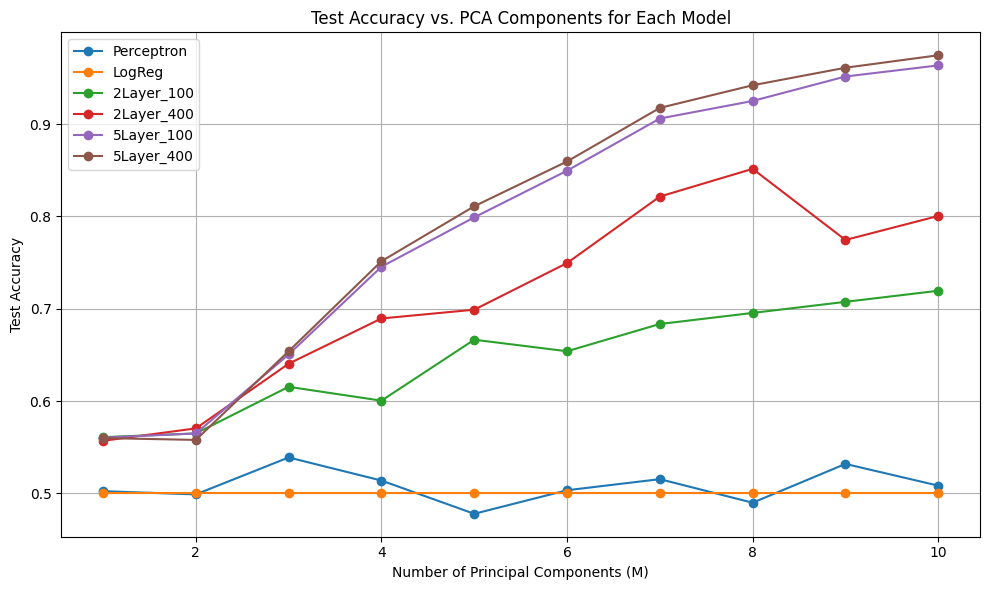

In [21]:
plt.figure(figsize=(10, 6))
Ms = list(range(1, 11))

for model_name, accs in results.items():
    plt.plot(Ms, accs, marker='o', label=model_name)

plt.xlabel("Number of Principal Components (M)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. PCA Components for Each Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [22]:
# --------- Kernel Functions ---------
def rbf_kernel(X, gamma):
    sq_dists = np.sum((X[:, np.newaxis] - X[np.newaxis, :]) ** 2, axis=2)
    return np.exp(-gamma * sq_dists)

def polynomial_kernel(X, degree, coef0):
    return (X @ X.T + coef0) ** degree

def center_kernel(K):
    N = K.shape[0]
    one_n = np.ones((N, N)) / N
    return K - one_n @ K - K @ one_n + one_n @ K @ one_n

# --------- Kernel PCA Implementation ---------
def kernel_pca(X, kernel='rbf', gamma=1.0, coef0=1.0, degree=2, n_components=10):
    # Step 1: Compute Kernel Matrix using kernel functions ## session crashes
    # if kernel == 'rbf':
    #     K = rbf_kernel(X, gamma)
    # elif kernel == 'poly':
    #     K = polynomial_kernel(X, degree, coef0)
    # else:
    #     raise ValueError("Unsupported kernel type. Use 'rbf' or 'poly'.")

    if kernel == 'rbf':
        K = pairwise_kernels(X, metric=kernel, gamma=gamma)
    elif kernel == 'poly':
        K = pairwise_kernels(X, metric=kernel, gamma=gamma, coef0=coef0, degree=degree)
    else:
        raise ValueError(f"Unsupported kernel: {kernel}")

    # Step 2: Center the Kernel Matrix
    K_centered = center_kernel(K)

    # Step 3: Eigen Decomposition
    eigvals, eigvecs = np.linalg.eigh(K_centered)

    # Step 4: Sort eigenvalues/eigenvectors in descending order
    idx = np.argsort(eigvals)[::-1]
    eigvals = eigvals[idx]
    eigvecs = eigvecs[:, idx]

    # Step 5: Normalize and return PC scores
    alphas = eigvecs[:, :n_components]
    lambdas = eigvals[:n_components]
    scores = alphas * np.sqrt(lambdas)

    return scores

In [23]:
def prepare_separate_kernel_pca_data(
    x4_train, x4_test, y4_train, y4_test,
    x9_train, x9_test, y9_train, y9_test,
    M=10, kernel='rbf', gamma=0.01, coef0=1.0, degree=2
):
    # Convert to numpy (required for sklearn pairwise_kernels)
    x4_train_np = x4_train.numpy()
    x4_test_np = x4_test.numpy()
    x9_train_np = x9_train.numpy()
    x9_test_np = x9_test.numpy()

    # Kernel PCA separately on digit 4
    X4_combined = np.vstack([x4_train_np, x4_test_np])
    kpca_4 = kernel_pca(X4_combined, kernel=kernel, gamma=gamma, coef0=coef0, degree=degree, n_components=M)
    z4_train = kpca_4[:len(x4_train)]
    z4_test = kpca_4[len(x4_train):]

    # Kernel PCA separately on digit 9
    X9_combined = np.vstack([x9_train_np, x9_test_np])
    kpca_9 = kernel_pca(X9_combined, kernel=kernel, gamma=gamma, coef0=coef0, degree=degree, n_components=M)
    z9_train = kpca_9[:len(x9_train)]
    z9_test = kpca_9[len(x9_train):]

    # Combine and return
    Z_train = np.vstack([z4_train, z9_train])
    Z_test = np.vstack([z4_test, z9_test])
    y_train = torch.cat([y4_train, y9_train])
    y_test = torch.cat([y4_test, y9_test])

    return Z_train, y_train, Z_test, y_test

In [24]:
# Store results
results = {
    "Perceptron": [],
    "LogReg": [],
    "2Layer_100": [],
    "2Layer_400": [],
    "5Layer_100": [],
    "5Layer_400": []
}

for M in range(1, 11):
    print(f"\n==== M = {M} ====")

    # Step 1: PCA separately for digits 4 and 9
    Z_train, y_train, Z_test, y_test = prepare_separate_kernel_pca_data(
    x4_train, x4_test, y4_train, y4_test,
    x9_train, x9_test, y9_train, y9_test,
    M=M, kernel='poly', gamma=0.01, coef0=1.0, degree=2
    )

    y_train_bin = map_labels(y_train)
    y_test_bin = map_labels(y_test)
    input_dim = Z_train.shape[1]

    # Step 2: Train and evaluate each model

    # Perceptron
    perceptron = Perceptron(max_iter=1000, tol=1e-3)
    y_pred_p = evaluate_sklearn_model(perceptron, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_p, tpr_p, fpr_p = compute_metrics(y_test_bin, y_pred_p)
    results["Perceptron"].append(acc_p)
    print(f"Perceptron    - Acc: {acc_p:.4f}, TPR: {tpr_p:.4f}, FPR: {fpr_p:.4f}")

    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    y_pred_l = evaluate_sklearn_model(logreg, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_l, tpr_l, fpr_l = compute_metrics(y_test_bin, y_pred_l)
    results["LogReg"].append(acc_l)
    print(f"Logistic Reg  - Acc: {acc_l:.4f}, TPR: {tpr_l:.4f}, FPR: {fpr_l:.4f}")

    # 2-layer NN (100)
    model_2_100 = TwoLayerNN(input_dim, 100)
    y_pred_2_100, _ = train_pytorch_model(model_2_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_100, tpr_2_100, fpr_2_100 = compute_metrics(y_test_bin, y_pred_2_100)
    results["2Layer_100"].append(acc_2_100)
    print(f"2-Layer (100) - Acc: {acc_2_100:.4f}, TPR: {tpr_2_100:.4f}, FPR: {fpr_2_100:.4f}")

    # 2-layer NN (400)
    model_2_400 = TwoLayerNN(input_dim, 400)
    y_pred_2_400, _ = train_pytorch_model(model_2_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_400, tpr_2_400, fpr_2_400 = compute_metrics(y_test_bin, y_pred_2_400)
    results["2Layer_400"].append(acc_2_400)
    print(f"2-Layer (400) - Acc: {acc_2_400:.4f}, TPR: {tpr_2_400:.4f}, FPR: {fpr_2_400:.4f}")

    # 5-layer NN (100)
    model_5_100 = FiveLayerNN(input_dim, 100)
    y_pred_5_100, _ = train_pytorch_model(model_5_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_100, tpr_5_100, fpr_5_100 = compute_metrics(y_test_bin, y_pred_5_100)
    results["5Layer_100"].append(acc_5_100)
    print(f"5-Layer (100) - Acc: {acc_5_100:.4f}, TPR: {tpr_5_100:.4f}, FPR: {fpr_5_100:.4f}")

    # 5-layer NN (400)
    model_5_400 = FiveLayerNN(input_dim, 400)
    y_pred_5_400, _ = train_pytorch_model(model_5_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_400, tpr_5_400, fpr_5_400 = compute_metrics(y_test_bin, y_pred_5_400)
    results["5Layer_400"].append(acc_5_400)
    print(f"5-Layer (400) - Acc: {acc_5_400:.4f}, TPR: {tpr_5_400:.4f}, FPR: {fpr_5_400:.4f}")


==== M = 1 ====
Perceptron    - Acc: 0.5000, TPR: 1.0000, FPR: 1.0000
Logistic Reg  - Acc: 0.5045, TPR: 0.5410, FPR: 0.5320
2-Layer (100) - Acc: 0.5570, TPR: 0.6790, FPR: 0.5650
2-Layer (400) - Acc: 0.5585, TPR: 0.6490, FPR: 0.5320
5-Layer (100) - Acc: 0.5610, TPR: 0.6170, FPR: 0.4950
5-Layer (400) - Acc: 0.5615, TPR: 0.6690, FPR: 0.5460

==== M = 2 ====
Perceptron    - Acc: 0.5015, TPR: 1.0000, FPR: 0.9970
Logistic Reg  - Acc: 0.5090, TPR: 0.5480, FPR: 0.5300
2-Layer (100) - Acc: 0.5705, TPR: 0.5930, FPR: 0.4520
2-Layer (400) - Acc: 0.5685, TPR: 0.6170, FPR: 0.4800
5-Layer (100) - Acc: 0.5730, TPR: 0.6670, FPR: 0.5210
5-Layer (400) - Acc: 0.5690, TPR: 0.5900, FPR: 0.4520

==== M = 3 ====
Perceptron    - Acc: 0.5005, TPR: 0.9700, FPR: 0.9690
Logistic Reg  - Acc: 0.4860, TPR: 0.5350, FPR: 0.5630
2-Layer (100) - Acc: 0.5730, TPR: 0.5790, FPR: 0.4330
2-Layer (400) - Acc: 0.5870, TPR: 0.5840, FPR: 0.4100
5-Layer (100) - Acc: 0.5920, TPR: 0.6400, FPR: 0.4560
5-Layer (400) - Acc: 0.5935, TP

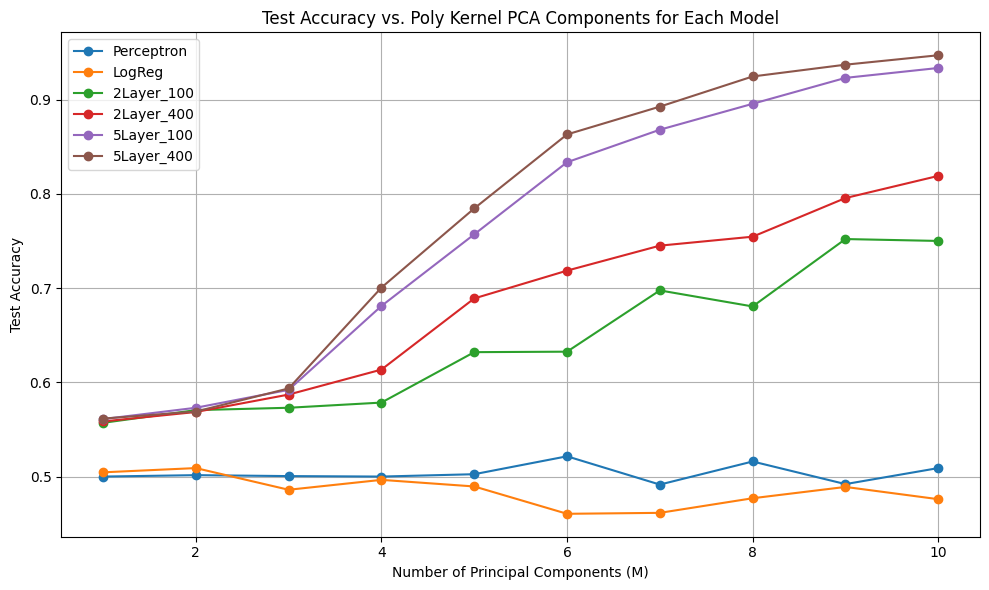

In [25]:
plt.figure(figsize=(10, 6))
Ms = list(range(1, 11))

for model_name, accs in results.items():
    plt.plot(Ms, accs, marker='o', label=model_name)

plt.xlabel("Number of Principal Components (M)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. Poly Kernel PCA Components for Each Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [26]:
# Store results
results = {
    "Perceptron": [],
    "LogReg": [],
    "2Layer_100": [],
    "2Layer_400": [],
    "5Layer_100": [],
    "5Layer_400": []
}

for M in range(1, 11):
    print(f"\n==== M = {M} ====")

    # Step 1: PCA separately for digits 4 and 9
    Z_train, y_train, Z_test, y_test = prepare_separate_kernel_pca_data(
    x4_train, x4_test, y4_train, y4_test,
    x9_train, x9_test, y9_train, y9_test,
    M=M, kernel='rbf', gamma=0.01, coef0=1.0, degree=2
    )

    y_train_bin = map_labels(y_train)
    y_test_bin = map_labels(y_test)
    input_dim = Z_train.shape[1]

    # Step 2: Train and evaluate each model

    # Perceptron
    perceptron = Perceptron(max_iter=1000, tol=1e-3)
    y_pred_p = evaluate_sklearn_model(perceptron, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_p, tpr_p, fpr_p = compute_metrics(y_test_bin, y_pred_p)
    results["Perceptron"].append(acc_p)
    print(f"Perceptron    - Acc: {acc_p:.4f}, TPR: {tpr_p:.4f}, FPR: {fpr_p:.4f}")

    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    y_pred_l = evaluate_sklearn_model(logreg, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_l, tpr_l, fpr_l = compute_metrics(y_test_bin, y_pred_l)
    results["LogReg"].append(acc_l)
    print(f"Logistic Reg  - Acc: {acc_l:.4f}, TPR: {tpr_l:.4f}, FPR: {fpr_l:.4f}")

    # 2-layer NN (100)
    model_2_100 = TwoLayerNN(input_dim, 100)
    y_pred_2_100, _ = train_pytorch_model(model_2_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_100, tpr_2_100, fpr_2_100 = compute_metrics(y_test_bin, y_pred_2_100)
    results["2Layer_100"].append(acc_2_100)
    print(f"2-Layer (100) - Acc: {acc_2_100:.4f}, TPR: {tpr_2_100:.4f}, FPR: {fpr_2_100:.4f}")

    # 2-layer NN (400)
    model_2_400 = TwoLayerNN(input_dim, 400)
    y_pred_2_400, _ = train_pytorch_model(model_2_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_400, tpr_2_400, fpr_2_400 = compute_metrics(y_test_bin, y_pred_2_400)
    results["2Layer_400"].append(acc_2_400)
    print(f"2-Layer (400) - Acc: {acc_2_400:.4f}, TPR: {tpr_2_400:.4f}, FPR: {fpr_2_400:.4f}")

    # 5-layer NN (100)
    model_5_100 = FiveLayerNN(input_dim, 100)
    y_pred_5_100, _ = train_pytorch_model(model_5_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_100, tpr_5_100, fpr_5_100 = compute_metrics(y_test_bin, y_pred_5_100)
    results["5Layer_100"].append(acc_5_100)
    print(f"5-Layer (100) - Acc: {acc_5_100:.4f}, TPR: {tpr_5_100:.4f}, FPR: {fpr_5_100:.4f}")

    # 5-layer NN (400)
    model_5_400 = FiveLayerNN(input_dim, 400)
    y_pred_5_400, _ = train_pytorch_model(model_5_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_400, tpr_5_400, fpr_5_400 = compute_metrics(y_test_bin, y_pred_5_400)
    results["5Layer_400"].append(acc_5_400)
    print(f"5-Layer (400) - Acc: {acc_5_400:.4f}, TPR: {tpr_5_400:.4f}, FPR: {fpr_5_400:.4f}")


==== M = 1 ====
Perceptron    - Acc: 0.5045, TPR: 0.5200, FPR: 0.5110
Logistic Reg  - Acc: 0.5000, TPR: 0.0000, FPR: 0.0000
2-Layer (100) - Acc: 0.5585, TPR: 0.5430, FPR: 0.4260
2-Layer (400) - Acc: 0.5565, TPR: 0.5990, FPR: 0.4860
5-Layer (100) - Acc: 0.5685, TPR: 0.6930, FPR: 0.5560
5-Layer (400) - Acc: 0.5665, TPR: 0.6720, FPR: 0.5390

==== M = 2 ====
Perceptron    - Acc: 0.5010, TPR: 0.5110, FPR: 0.5090
Logistic Reg  - Acc: 0.4875, TPR: 0.5100, FPR: 0.5350
2-Layer (100) - Acc: 0.5770, TPR: 0.5500, FPR: 0.3960
2-Layer (400) - Acc: 0.5770, TPR: 0.5710, FPR: 0.4170
5-Layer (100) - Acc: 0.5795, TPR: 0.6190, FPR: 0.4600
5-Layer (400) - Acc: 0.5750, TPR: 0.5650, FPR: 0.4150

==== M = 3 ====
Perceptron    - Acc: 0.5045, TPR: 0.4990, FPR: 0.4900
Logistic Reg  - Acc: 0.4835, TPR: 0.5190, FPR: 0.5520
2-Layer (100) - Acc: 0.5935, TPR: 0.5740, FPR: 0.3870
2-Layer (400) - Acc: 0.6035, TPR: 0.5840, FPR: 0.3770
5-Layer (100) - Acc: 0.5865, TPR: 0.5500, FPR: 0.3770
5-Layer (400) - Acc: 0.6085, TP

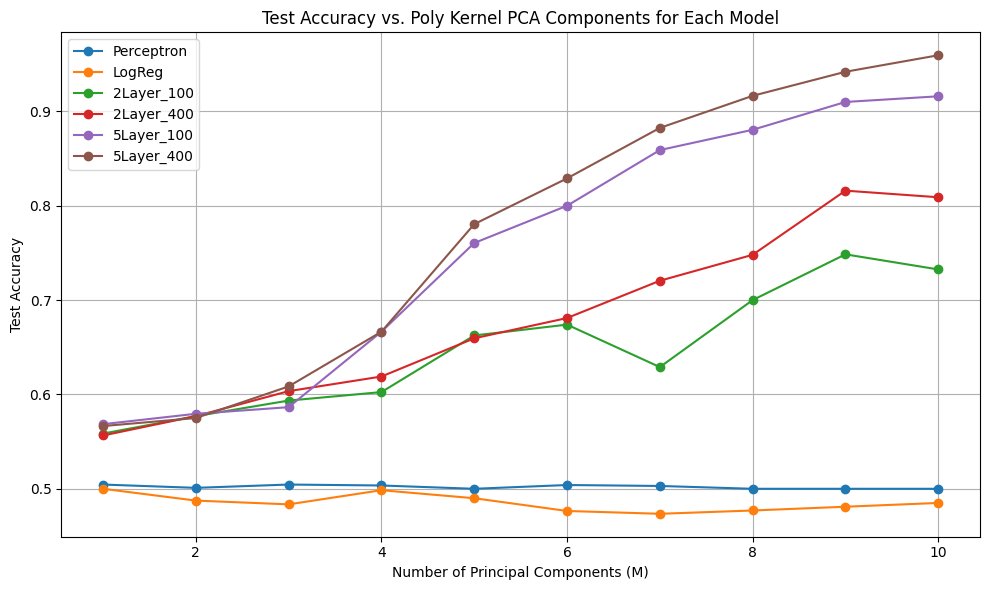

In [27]:
plt.figure(figsize=(10, 6))
Ms = list(range(1, 11))

for model_name, accs in results.items():
    plt.plot(Ms, accs, marker='o', label=model_name)

plt.xlabel("Number of Principal Components (M)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. RBF Kernel PCA Components for Each Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [10]:
class BetaVAE(nn.Module):
    def __init__(self, latent_dim):
        super(BetaVAE, self).__init__()
        self.fc1 = nn.Linear(784, 400)
        self.fc_mu = nn.Linear(400, latent_dim)
        self.fc_logvar = nn.Linear(400, latent_dim)
        self.fc2 = nn.Linear(latent_dim, 400)
        self.fc3 = nn.Linear(400, 784)

    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc_mu(h), self.fc_logvar(h)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc2(z))
        return torch.sigmoid(self.fc3(h))

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        x_recon = self.decode(z)
        return x_recon, mu, logvar

def loss_function(x_recon, x, mu, logvar, beta):
    BCE = F.binary_cross_entropy(x_recon, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + beta * KLD, BCE, KLD

In [11]:
def train_beta_vae(model, data, epochs=100, batch_size=128, beta=0.01, lr=1e-3):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    loader = DataLoader(TensorDataset(data), batch_size=batch_size, shuffle=True)
    model.train()
    for epoch in range(epochs):
        for batch in loader:
            x = batch[0]
            optimizer.zero_grad()
            x_recon, mu, logvar = model(x)
            loss, _, _ = loss_function(x_recon, x, mu, logvar, beta)
            loss.backward()
            optimizer.step()
    return model

def get_latent_means(model, data, batch_size=128):
    loader = DataLoader(TensorDataset(data), batch_size=batch_size)
    model.eval()
    mus = []
    with torch.no_grad():
        for batch in loader:
            x = batch[0]
            mu, _ = model.encode(x)
            mus.append(mu)
    return torch.cat(mus, dim=0)

In [12]:
def prepare_vae_latents_by_class(
    x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test,
    M=10, beta=0.01, epochs=100
):
    # Train VAE on digit 4
    vae_4 = BetaVAE(latent_dim=M)
    vae_4 = train_beta_vae(vae_4, x4_train, epochs=epochs, beta=beta)
    z4_train = get_latent_means(vae_4, x4_train)
    z4_test = get_latent_means(vae_4, x4_test)

    # Train VAE on digit 9
    vae_9 = BetaVAE(latent_dim=M)
    vae_9 = train_beta_vae(vae_9, x9_train, epochs=epochs, beta=beta)
    z9_train = get_latent_means(vae_9, x9_train)
    z9_test = get_latent_means(vae_9, x9_test)

    # Combine train and test sets
    Z_train = torch.cat([z4_train, z9_train], dim=0).numpy()
    Z_test = torch.cat([z4_test, z9_test], dim=0).numpy()
    y_train = torch.cat([y4_train, y9_train])
    y_test = torch.cat([y4_test, y9_test])

    return Z_train, y_train, Z_test, y_test

In [40]:
# Store results
results = {
    "Perceptron": [],
    "LogReg": [],
    "2Layer_100": [],
    "2Layer_400": [],
    "5Layer_100": [],
    "5Layer_400": []
}

for M in range(1, 5):
    print(f"\n==== M = {M} ====")

    # Step 1: PCA separately for digits 4 and 9
    Z_train, y_train, Z_test, y_test = prepare_vae_latents_by_class(
    x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test,
    M=M, beta=0.01, epochs=100)


    y_train_bin = map_labels(y_train)
    y_test_bin = map_labels(y_test)
    input_dim = Z_train.shape[1]

    # Step 2: Train and evaluate each model

    # Perceptron
    perceptron = Perceptron(max_iter=1000, tol=1e-3)
    y_pred_p = evaluate_sklearn_model(perceptron, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_p, tpr_p, fpr_p = compute_metrics(y_test_bin, y_pred_p)
    results["Perceptron"].append(acc_p)
    print(f"Perceptron    - Acc: {acc_p:.4f}, TPR: {tpr_p:.4f}, FPR: {fpr_p:.4f}")

    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    y_pred_l = evaluate_sklearn_model(logreg, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_l, tpr_l, fpr_l = compute_metrics(y_test_bin, y_pred_l)
    results["LogReg"].append(acc_l)
    print(f"Logistic Reg  - Acc: {acc_l:.4f}, TPR: {tpr_l:.4f}, FPR: {fpr_l:.4f}")

    # 2-layer NN (100)
    model_2_100 = TwoLayerNN(input_dim, 100)
    y_pred_2_100, _ = train_pytorch_model(model_2_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_100, tpr_2_100, fpr_2_100 = compute_metrics(y_test_bin, y_pred_2_100)
    results["2Layer_100"].append(acc_2_100)
    print(f"2-Layer (100) - Acc: {acc_2_100:.4f}, TPR: {tpr_2_100:.4f}, FPR: {fpr_2_100:.4f}")

    # 2-layer NN (400)
    model_2_400 = TwoLayerNN(input_dim, 400)
    y_pred_2_400, _ = train_pytorch_model(model_2_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_400, tpr_2_400, fpr_2_400 = compute_metrics(y_test_bin, y_pred_2_400)
    results["2Layer_400"].append(acc_2_400)
    print(f"2-Layer (400) - Acc: {acc_2_400:.4f}, TPR: {tpr_2_400:.4f}, FPR: {fpr_2_400:.4f}")

    # 5-layer NN (100)
    model_5_100 = FiveLayerNN(input_dim, 100)
    y_pred_5_100, _ = train_pytorch_model(model_5_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_100, tpr_5_100, fpr_5_100 = compute_metrics(y_test_bin, y_pred_5_100)
    results["5Layer_100"].append(acc_5_100)
    print(f"5-Layer (100) - Acc: {acc_5_100:.4f}, TPR: {tpr_5_100:.4f}, FPR: {fpr_5_100:.4f}")

    # 5-layer NN (400)
    model_5_400 = FiveLayerNN(input_dim, 400)
    y_pred_5_400, _ = train_pytorch_model(model_5_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_400, tpr_5_400, fpr_5_400 = compute_metrics(y_test_bin, y_pred_5_400)
    results["5Layer_400"].append(acc_5_400)
    print(f"5-Layer (400) - Acc: {acc_5_400:.4f}, TPR: {tpr_5_400:.4f}, FPR: {fpr_5_400:.4f}")


==== M = 1 ====
Perceptron    - Acc: 0.8965, TPR: 0.9770, FPR: 0.1840
Logistic Reg  - Acc: 0.9320, TPR: 0.9240, FPR: 0.0600
2-Layer (100) - Acc: 0.9285, TPR: 0.9100, FPR: 0.0530
2-Layer (400) - Acc: 0.9315, TPR: 0.9230, FPR: 0.0600
5-Layer (100) - Acc: 0.9320, TPR: 0.9280, FPR: 0.0640
5-Layer (400) - Acc: 0.9320, TPR: 0.9240, FPR: 0.0600

==== M = 2 ====
Perceptron    - Acc: 0.7830, TPR: 0.9640, FPR: 0.3980
Logistic Reg  - Acc: 0.8815, TPR: 0.8810, FPR: 0.1180
2-Layer (100) - Acc: 0.8810, TPR: 0.8880, FPR: 0.1260
2-Layer (400) - Acc: 0.8800, TPR: 0.8750, FPR: 0.1150
5-Layer (100) - Acc: 0.8805, TPR: 0.8380, FPR: 0.0770
5-Layer (400) - Acc: 0.8775, TPR: 0.8430, FPR: 0.0880

==== M = 3 ====
Perceptron    - Acc: 0.7265, TPR: 0.5100, FPR: 0.0570
Logistic Reg  - Acc: 0.8225, TPR: 0.8260, FPR: 0.1810
2-Layer (100) - Acc: 0.8555, TPR: 0.8520, FPR: 0.1410
2-Layer (400) - Acc: 0.8670, TPR: 0.8660, FPR: 0.1320
5-Layer (100) - Acc: 0.8740, TPR: 0.8720, FPR: 0.1240
5-Layer (400) - Acc: 0.8695, TP

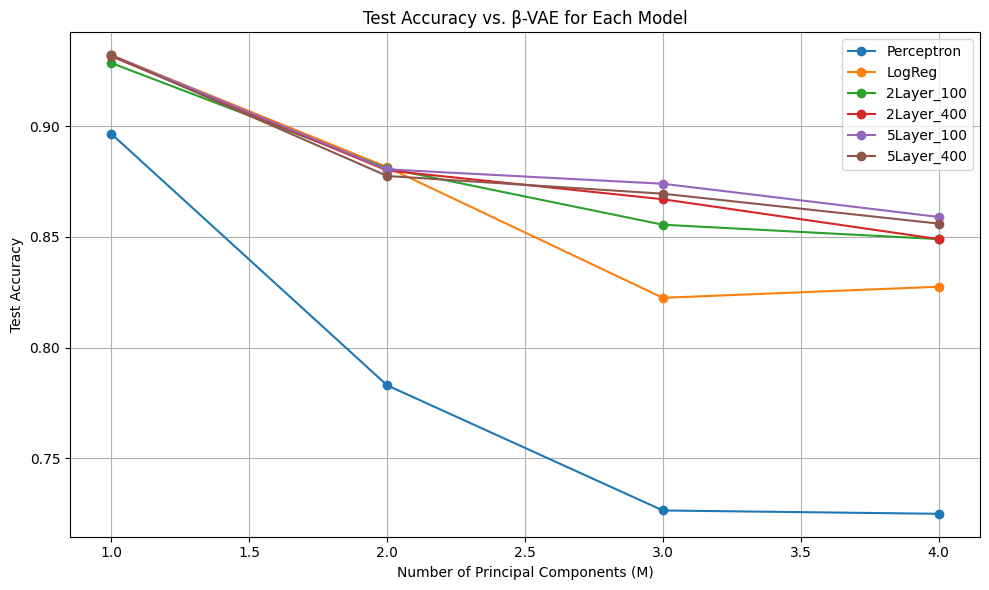

In [42]:
plt.figure(figsize=(10, 6))
Ms = list(range(1, 5))

for model_name, accs in results.items():
    plt.plot(Ms, accs, marker='o', label=model_name)

plt.xlabel("Number of Principal Components (M)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. β-VAE for Each Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

In [16]:
# Store results
results = {
    "Perceptron": [],
    "LogReg": [],
    "2Layer_100": [],
    "2Layer_400": [],
    "5Layer_100": [],
    "5Layer_400": []
}

for M in range(1, 5):
    print(f"\n==== M = {M} ====")

    # Step 1: PCA separately for digits 4 and 9
    Z_train, y_train, Z_test, y_test = prepare_vae_latents_by_class(
    x4_train, x4_test, y4_train, y4_test, x9_train, x9_test, y9_train, y9_test,
    M=M, beta=1, epochs=100)


    y_train_bin = map_labels(y_train)
    y_test_bin = map_labels(y_test)
    input_dim = Z_train.shape[1]

    # Step 2: Train and evaluate each model

    # Perceptron
    perceptron = Perceptron(max_iter=1000, tol=1e-3)
    y_pred_p = evaluate_sklearn_model(perceptron, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_p, tpr_p, fpr_p = compute_metrics(y_test_bin, y_pred_p)
    results["Perceptron"].append(acc_p)
    print(f"Perceptron    - Acc: {acc_p:.4f}, TPR: {tpr_p:.4f}, FPR: {fpr_p:.4f}")

    # Logistic Regression
    logreg = LogisticRegression(max_iter=1000)
    y_pred_l = evaluate_sklearn_model(logreg, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_l, tpr_l, fpr_l = compute_metrics(y_test_bin, y_pred_l)
    results["LogReg"].append(acc_l)
    print(f"Logistic Reg  - Acc: {acc_l:.4f}, TPR: {tpr_l:.4f}, FPR: {fpr_l:.4f}")

    # 2-layer NN (100)
    model_2_100 = TwoLayerNN(input_dim, 100)
    y_pred_2_100, _ = train_pytorch_model(model_2_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_100, tpr_2_100, fpr_2_100 = compute_metrics(y_test_bin, y_pred_2_100)
    results["2Layer_100"].append(acc_2_100)
    print(f"2-Layer (100) - Acc: {acc_2_100:.4f}, TPR: {tpr_2_100:.4f}, FPR: {fpr_2_100:.4f}")

    # 2-layer NN (400)
    model_2_400 = TwoLayerNN(input_dim, 400)
    y_pred_2_400, _ = train_pytorch_model(model_2_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_2_400, tpr_2_400, fpr_2_400 = compute_metrics(y_test_bin, y_pred_2_400)
    results["2Layer_400"].append(acc_2_400)
    print(f"2-Layer (400) - Acc: {acc_2_400:.4f}, TPR: {tpr_2_400:.4f}, FPR: {fpr_2_400:.4f}")

    # 5-layer NN (100)
    model_5_100 = FiveLayerNN(input_dim, 100)
    y_pred_5_100, _ = train_pytorch_model(model_5_100, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_100, tpr_5_100, fpr_5_100 = compute_metrics(y_test_bin, y_pred_5_100)
    results["5Layer_100"].append(acc_5_100)
    print(f"5-Layer (100) - Acc: {acc_5_100:.4f}, TPR: {tpr_5_100:.4f}, FPR: {fpr_5_100:.4f}")

    # 5-layer NN (400)
    model_5_400 = FiveLayerNN(input_dim, 400)
    y_pred_5_400, _ = train_pytorch_model(model_5_400, Z_train, y_train_bin, Z_test, y_test_bin)
    acc_5_400, tpr_5_400, fpr_5_400 = compute_metrics(y_test_bin, y_pred_5_400)
    results["5Layer_400"].append(acc_5_400)
    print(f"5-Layer (400) - Acc: {acc_5_400:.4f}, TPR: {tpr_5_400:.4f}, FPR: {fpr_5_400:.4f}")


==== M = 1 ====
Perceptron    - Acc: 0.5230, TPR: 0.7190, FPR: 0.6730
Logistic Reg  - Acc: 0.5045, TPR: 0.5010, FPR: 0.4920
2-Layer (100) - Acc: 0.5325, TPR: 0.3690, FPR: 0.3040
2-Layer (400) - Acc: 0.5540, TPR: 0.4730, FPR: 0.3650
5-Layer (100) - Acc: 0.5575, TPR: 0.4740, FPR: 0.3590
5-Layer (400) - Acc: 0.5625, TPR: 0.5340, FPR: 0.4090

==== M = 2 ====
Perceptron    - Acc: 0.5270, TPR: 0.5940, FPR: 0.5400
Logistic Reg  - Acc: 0.5680, TPR: 0.5410, FPR: 0.4050
2-Layer (100) - Acc: 0.6005, TPR: 0.4950, FPR: 0.2940
2-Layer (400) - Acc: 0.6010, TPR: 0.4950, FPR: 0.2930
5-Layer (100) - Acc: 0.6170, TPR: 0.5200, FPR: 0.2860
5-Layer (400) - Acc: 0.6105, TPR: 0.5270, FPR: 0.3060

==== M = 3 ====
Perceptron    - Acc: 0.4840, TPR: 0.7240, FPR: 0.7560
Logistic Reg  - Acc: 0.5910, TPR: 0.5760, FPR: 0.3940
2-Layer (100) - Acc: 0.6475, TPR: 0.6270, FPR: 0.3320
2-Layer (400) - Acc: 0.6740, TPR: 0.6770, FPR: 0.3290
5-Layer (100) - Acc: 0.6800, TPR: 0.6980, FPR: 0.3380
5-Layer (400) - Acc: 0.6725, TP

In [ ]:
plt.figure(figsize=(10, 6))
Ms = list(range(1, 5))

for model_name, accs in results.items():
    plt.plot(Ms, accs, marker='o', label=model_name)

plt.xlabel("Number of Principal Components (M)")
plt.ylabel("Test Accuracy")
plt.title("Test Accuracy vs. β-VAE for Each Model")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()